In [1]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
energy_df = pd.read_csv("../data/extended_energy_data.csv")
energy_df.bfill(inplace=True)
energy_df.set_index("date", inplace=True)
energy_df.index = pd.to_datetime(energy_df.index)
energy_df = energy_df.resample("h").sum()

In [3]:
energy_df

hvac_N     hvac_S  air_temp_set_1  air_temp_set_2  \
date                                                                         
2018-01-01 00:00:00  149.600006  78.000000          46.160          45.850   
2018-01-01 01:00:00  150.100002  77.579998          43.560          43.730   
2018-01-01 02:00:00  151.000004  91.100000          43.020          43.200   
2018-01-01 03:00:00  150.200005  75.680000          41.910          42.190   
2018-01-01 04:00:00  146.700005  86.400000          39.970          40.590   
...                         ...        ...             ...             ...   
2020-12-31 20:00:00   98.483971  83.099649          51.078          44.684   
2020-12-31 21:00:00  100.596190  80.819533          56.156          49.477   
2020-12-31 22:00:00  105.769298  88.237961          60.655          53.056   
2020-12-31 23:00:00  110.242936  88.951773          58.988          53.917   
2021-01-01 00:00:00   29.843889  23.788947          13.856          13.383   

                     dew_point_temperature_set_1d  relative_humidity_set_1  \
date                                                                         
2018-01-01 00:00:00                         32.56                   319.29   
2018-01-01 01:00:00                         31.98                   330.00   
2018-01-01 02:00:00                         31.84                   332.10   
2018-01-01 03:00:00                         32.14                   340.00   
2018-01-01 04:00:00                         32.03                   350.40   
...                                           ...                      ...   
2020-12-31 20:00:00                         16.20                   222.79   
2020-12-31 21:00:00                         16.69                   206.86   
2020-12-31 22:00:00                         15.31                   187.71   
2020-12-31 23:00:00                         16.99                   198.63   
2021-01-01 00:00:00                          4.64                    54.03   

                     solar_radiation_set_1  
date                                        
2018-01-01 00:00:00                 205.63  
2018-01-01 01:00:00                   8.50  
2018-01-01 02:00:00                   0.00  
2018-01-01 03:00:00                   0.00  
2018-01-01 04:00:00                   0.00  
...                                    ...  
2020-12-31 20:00:00                1821.80  
2020-12-31 21:00:00                1736.20  
2020-12-31 22:00:00                1445.60  
2020-12-31 23:00:00                 910.80  
2021-01-01 00:00:00                 124.70  

[26305 rows x 7 columns]

In [4]:
energy_data = energy_df.loc[:, ['hvac_N']].ewm(com =2).mean()

#encode index sinusoidal for day of the week

scaler = StandardScaler()


energy_data['day_of_week'] = energy_data.index.dayofweek
energy_data['hour_of_day'] = energy_data.index.hour
energy_data['scaled_hvac_N'] = scaler.fit_transform(energy_data[['hvac_N']])


In [5]:
energy_data['day_encoding'] = np.sin(2*np.pi*energy_data['day_of_week']/7)
energy_data['hour_encoding'] = np.sin(2*np.pi*energy_data['hour_of_day']/24)
energy_data['month_encoding'] = np.sin(2*np.pi*energy_data.index.month/12)

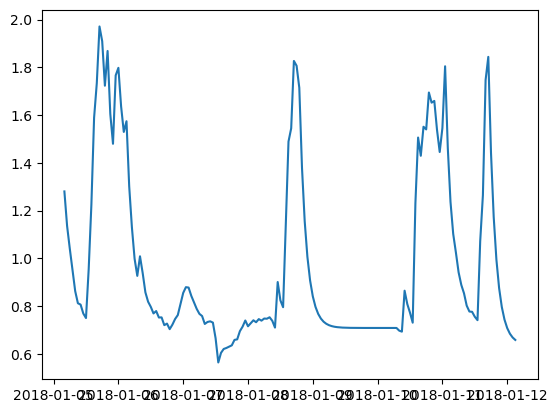

In [6]:
plt.plot(energy_data['scaled_hvac_N'][100+0:100+168])

In [7]:
data = energy_data.loc[:,['scaled_hvac_N', 'day_encoding', 'hour_encoding', 'month_encoding']]

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

In [9]:
# create dataset for lstm with window_size

window_size = 7*24

def create_dataset(data, window_size):
    data = data.values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

In [10]:
# shuffle X_train and y_train  
shuffle_idx = np.random.permutation(len(X_train))
X_train = X_train[shuffle_idx]
y_train = y_train[shuffle_idx]

In [11]:
X_train.shape

(16667, 168, 4)

In [12]:
model = keras.models.Sequential()
model.add(keras.Input(shape = (X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.LSTM(50,  return_sequences = True))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dense(1))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data = (X_val, y_val), verbose = 1, epochs = 10)

Epoch 1/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - loss: 0.1708 - val_loss: 0.0219
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - loss: 0.0143 - val_loss: 0.0078
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 80s 154ms/step - loss: 0.0113 - val_loss: 0.0068
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - loss: 0.0113 - val_loss: 0.0070
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 79s 152ms/step - loss: 0.0108 - val_loss: 0.0097
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - loss: 0.0116 - val_loss: 0.0067
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 79s 151ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 8/10
367/521 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.0112

KeyboardInterrupt: 

In [15]:
# predict on test

y_pred = model.predict(X_test)


160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


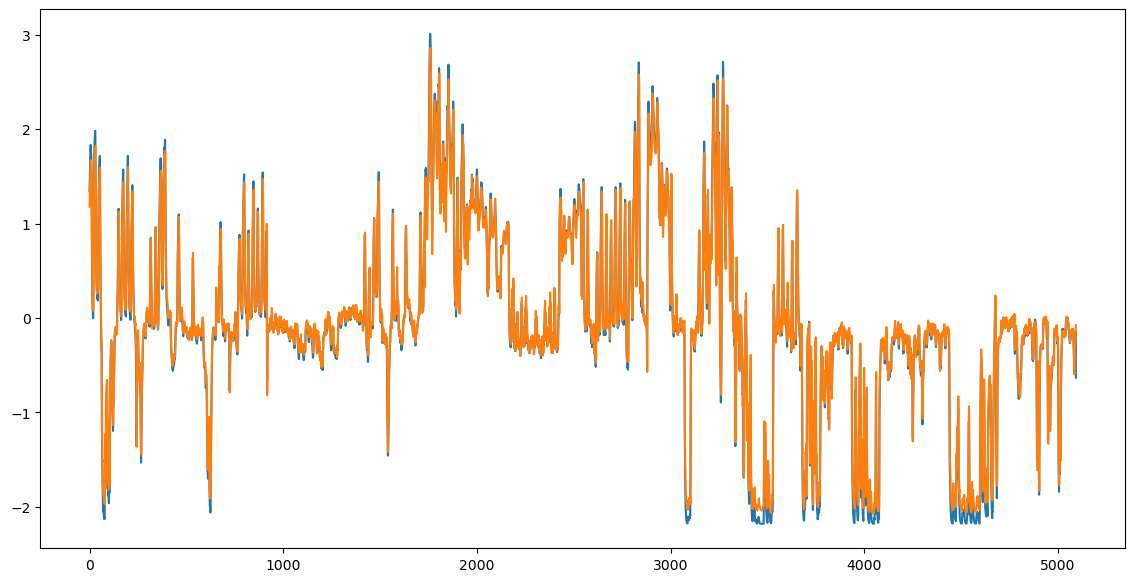

In [16]:
# plot y_test and y_pred

plt.figure(figsize=(14, 7))
plt.plot(y_test, label = 'True')
plt.plot(y_pred, label = 'Predicted')

In [18]:
# get weekly data from test_data_df 

weekly_window = 7*24
daily_window = 24

def create_forecast_dataset(data):
    X, y = [], []

    for i in range(len(data) - weekly_window - daily_window):
        X.append(data[i:i+weekly_window])
        y.append(data[i+weekly_window:i+weekly_window+daily_window])

    return np.array(X), np.array(y)
    


In [19]:
X, y = create_forecast_dataset(train_data)

In [20]:
X.shape

(16643, 168, 4)

In [21]:
y.shape

(16643, 24, 4)

In [22]:
y[100][2][1:]

array([-0.43388374,  1.        ,  0.5       ])

In [23]:
input_data = X[200]
y_forecast = []
for i in range(24):
    y_forecast.append(model.predict(input_data.reshape(1, weekly_window, 4), verbose = False).flatten().item())
    new_time_encodings = y[200][i][1:]
    new_input = np.concatenate([np.array(y_forecast[-1]).reshape(1,1), new_time_encodings.reshape(1,3)], axis=1)
    input_data = np.concatenate([input_data[1:], new_input], axis=0)


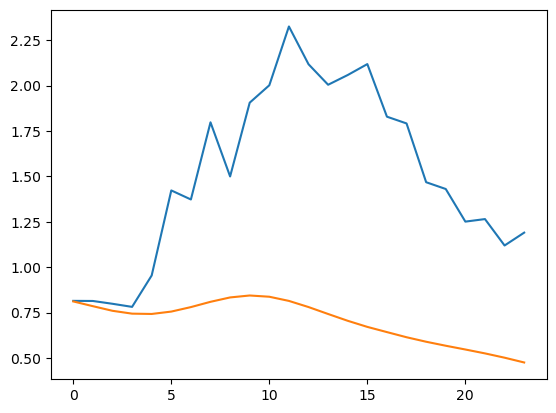

In [24]:
plt.plot(y[200,:,0])
plt.plot(y_forecast)